In [41]:
import pickle, glob, ast

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

from matplotlib import rc
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import savgol_filter
from scipy import fftpack
from scipy import stats
from scipy.stats import multivariate_normal, norm
from scipy.ndimage.filters import gaussian_filter1d

import statsmodels.api as sm

from statsmodels.nonparametric.kernel_regression import KernelReg

from ast import literal_eval
from mpl_toolkits.axisartist.axislines import AxesZero
from matplotlib.ticker import StrMethodFormatter, NullFormatter, ScalarFormatter
from shapely.geometry import Point
from matplotlib.transforms import ScaledTranslation

import matplotlib as mpl

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
#mpl.rcParams['pdf.fonttype'] = 42

path_to_images  = r'/Users/Guille/Desktop/caiso_power/images/'
path_to_aux     = r'/Users/Guille/Desktop/caiso_power/data/auxiliary/'
path_to_data    = r'/Users/Guille/Desktop/caiso_power/data/'
path_to_maps    = r'/Users/Guille/Desktop/caiso_power/data/maps/'
path_to_prc     = r'/Users/Guille/Desktop/caiso_power/data/processed/'

# Get California unlities and remove the ones that are not CAISO
_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
_US    = gpd.read_file(path_to_maps + r"US/tl_2022_us_state.shp")
_CAISO = gpd.read_file(path_to_maps + r"CAISO/Balancing_Authority_Areas_in_CA.shp")
_CAISO = _CAISO.iloc[[1, 7]].to_crs("EPSG:4326")
W_ref_ = pickle.load(open(path_to_aux + r'ref_grid_0.125_(-125,-112)_(32,43).pkl', 'rb'))

resources_  = ['load', 'solar', 'wind']
dl_methods_ = ['BLR', 'RVM', 'GPR']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']

colors_1_ = ['#7d6674', '#006995', '#f48d64', '#09155a', '#e6cd94', '#0041a5']
colors_2_ = ['#126463', '#2CB7B5', '#CA8250']
colors_3_ = ['#1F390D', '#756A00', '#D8A581', '#92918B']

kernels_ = ['$\mathcal{K}_L$', 
            '$\mathcal{K}_{RFB}$', 
            '$\mathcal{K}_{P^2}$', 
            '$\mathcal{K}_{P^3}$', 
            '$\mathcal{K}_{M_{0.5}}$', 
            '$\mathcal{K}_{M_{1.5}}$', 
            '$\mathcal{K}_{M_{2.5}}$', 
            '$\mathcal{K}_{RQ}$']    

/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_97497/2653482513.py:21: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


# Independent Energy Forecast Model Selection

## Load Independent Energy Forecast Results

In [42]:
def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

from scipy.stats import norm, multivariate_normal

# Energy Score across time
def _ES(Y_, Y_hat_):

    N_observation, N_tasks, N_horizons, N_scen = Y_hat_.shape

    score_ = np.zeros((N_observation))
    Y_     = np.concatenate([Y_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    Y_hat_ = np.concatenate([Y_hat_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)

    for n in range(N_observation):
        Y_p_   = np.tile(Y_[n, :], (N_scen, 1)).T
        frac1_ = np.sqrt(np.diag((Y_hat_[n, :, :] - Y_p_).T @ (Y_hat_[n, :, :] - Y_p_)))
        frac2_ = 0
        for m in range(N_scen):
            frac2_ += np.sqrt(np.sum((Y_hat_[n, :, :].T - Y_hat_[n, :, m])**2, axis = 1))
        score_[n] = (np.sum(frac1_)/N_scen) - (np.sum(frac2_)/(2*(N_scen**2)))
    return score_

# Variogram Score computed across temporal dimensions
def _VS(Y_, Y_hat_, p = .5):
    N_observation, N_tasks, N_horizons, N_scen = Y_hat_.shape
    score_ = np.zeros((N_observation))
    Y_     = np.concatenate([Y_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    Y_hat_ = np.concatenate([Y_hat_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    for n in range(N_observation):
        frac1_ = np.absolute(np.subtract.outer(Y_[n, ], Y_[n, :]))**p
        frac2_ = np.zeros((N_horizons*N_tasks, N_horizons*N_tasks))
        for m in range(N_scen):
            frac2_ += np.absolute(np.subtract.outer(Y_hat_[n, :, m], Y_hat_[n, :, m]))**p
        score_[n] = np.sum((frac1_ - (frac2_/N_scen))**2)
    return score_

def _IS(Y_, M_, S2_, z, alpha):
    
    # Interval Score
    def __IS(y_, alpha, lower_, upper_):
        score_  = (upper_ - lower_)
        score_ += (2./alpha)*(lower_ - y_) * (1*(y_ < lower_))
        score_ += (2./alpha)*(y_ - upper_) * (1*(y_ > upper_))
        return score_
    # 95% CI: z = 1.96; alpha = 0.05
    # 90% CI: z = 1.645; alpha = 0.1
    N_observation, N_horizons = M_.shape
    # Y_     = np.concatenate([Y_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # M_     = np.concatenate([M_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # S2_    = np.concatenate([S2_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    score_ = np.zeros((N_observation,))
    for n in range(N_observation):
        score_[n] = __IS(Y_[n, :], alpha, lower_ = M_[n, :] - z*np.sqrt(S2_[n, :]),
                                          upper_ = M_[n, :] + z*np.sqrt(S2_[n, :])).sum()
    return score_

def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

def _load_test_scores(resources_, sl_methods_, dl_methods_, scores_, path):
    
    df_ = []
    for resource in resources_:
        print(resource)
        param_ = pd.read_csv(path + f'prob_model_selection_{resource}.csv')
        for score in scores_:
            for sl_method in sl_methods_:
                for dl_method in dl_methods_:
                    
                    with open(path + '{}-{}-{}-{}.pkl'.format(resource, sl_method, dl_method, score), 'rb') as f:
                        _model = pickle.load(f)  
                    idx_   = (param_['sparse_method'] == sl_method) & (param_['dense_method'] == dl_method)
                    thetas = param_.loc[idx_ & (param_['score'] == score) , 'parameters'].tolist()[0]
                    
                    N_samples, N_tasks, N_horizons = _model['mean'].shape
                    Z = N_samples*N_tasks*N_horizons
                    
                    Y_      = np.sum(_model['targets'], axis = 1)
                    Y_iso_  = np.sum(_model['caiso'], axis = 1)
                    Y_mean_ = np.sum(_model['mean'], axis = 1)
                    Y_var_  = np.sum(_model['variance'], axis = 1)

                    tr = _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
                    ts = (_model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time'])/N_samples
                    
                    IS975 = _IS(Y_, Y_mean_, Y_var_, z = 2.243, alpha = 0.025).sum()/Z
                    IS95  = _IS(Y_, Y_mean_, Y_var_, z = 1.959, alpha = 0.05).sum()/Z
                    IS90  = _IS(Y_, Y_mean_, Y_var_, z = 1.645, alpha = 0.1).sum()/Z
                    IS80  = _IS(Y_, Y_mean_, Y_var_, z = 1.282, alpha = 0.2).sum()/Z
                    IS60  = _IS(Y_, Y_mean_, Y_var_, z = 0.842, alpha = 0.4).sum()/Z

                    #LogS = -z_.sum()/Z
                    RMSE = _RMSE(Y_, Y_mean_).mean()
                    FS   = 100*(1. - _RMSE(Y_, Y_mean_).sum()/_RMSE(Y_, Y_iso_).sum())
                    ES   = _ES(_model['targets'], _model['samples']).sum()/Z
                    VS   = _VS(_model['targets'], _model['samples']).sum()/Z
                    IS   = IS60 + IS80 + IS90 + IS95 + IS975 

                    df_.append([sl_method, dl_method, thetas, resource, score, RMSE, FS, ES, VS, IS, IS60, IS80, IS90, IS95, IS975, tr, ts])

    return pd.DataFrame(df_, columns = ['sparse_method', 'dense_method', 'parameters', 'resource', 'score', 'RMSE', 'FS', 'ES', 'VS', 'IS', 'IS60', 'IS80', 'IS90','IS95', 'IS975', 'train', 'test'])

path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

resources_  = ['load', 'solar', 'wind']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']
zones_      = ['NP15', 'SP15', 'ZP26']
scores_     = ['ES', 'VS', 'IS']

ts_scores_ = _load_test_scores(resources_, sl_methods_, dl_methods_, scores_, path_to_mdls)

ts_scores_['RMSE']  = ts_scores_['RMSE'].astype(float)
ts_scores_['FS']    = ts_scores_['FS'].astype(float)
ts_scores_['ES']    = ts_scores_['ES'].astype(float)
ts_scores_['VS']    = ts_scores_['VS'].astype(float)
ts_scores_['IS']    = ts_scores_['IS'].astype(float)
ts_scores_['IS60']  = ts_scores_['IS60'].astype(float)
ts_scores_['IS80']  = ts_scores_['IS80'].astype(float)
ts_scores_['IS90']  = ts_scores_['IS90'].astype(float)
ts_scores_['IS95']  = ts_scores_['IS95'].astype(float)
ts_scores_['IS975'] = ts_scores_['IS975'].astype(float)
ts_scores_['train'] = ts_scores_['train'].astype(float)
ts_scores_['test']  = ts_scores_['test'].astype(float)
#print(ts_scores_.loc[(ts_scores_['score'] == 'ES') & (ts_scores_['resource'] == 'load')])

load
solar
wind


## Independent Energy Forecast - Interval Score

In [43]:
def _plot_interval_scores(ax, Scores_, zones_p_, colors_, resource, 
                          legend_labels_  = [], 
                          legend_title    = '' , 
                          score           = '', 
                          xlabel          = '',
                          ylabel          = '', 
                          title           = '', 
                          y_min           = 0,
                          y_max           = 3000,
                          legend          = False):
    

    interval_scores_ = ['IS60','IS80','IS90','IS95', 'IS975']
    dense_methods_   = Scores_['dense_method'].unique()

    x_ = np.linspace(0, .333*len(dense_methods_), len(dense_methods_))
    
    ax.set_title(title, size = 18)

    width  = 0.4
    offset = 2.

    ticks_  = []
    values_ = []
    j = 0
    legend_labels_ = []
    for interval_score in interval_scores_:
        i = 0
        for dense_method in dense_methods_:
            kernel = ''
            idx_1_ = (Scores_['dense_method'] == dense_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score)
            df_ = Scores_.loc[idx_1_ & (Scores_['IS'] == Scores_.loc[idx_1_, 'IS'].min())]

            if (j == 0):
                sparse_method = df_['sparse_method'].to_list()[0].replace('_', ' ').title()
                if sparse_method == 'Omp': 
                    sparse_method = 'OMP'
                    
                if (dense_method == 'GPR') | (dense_method == 'MTGPR'):
                    i_kernel = int(ast.literal_eval(df_['parameters'].to_list()[0])[-1])
                    kernel = f' ({kernels_[i_kernel]})'

                label = r'{} + {}'.format(sparse_method, dense_method) + kernel
                legend_labels_.append(label)
                
            p = ax.bar(x_[i], df_[interval_score].min(), width, color  = colors_[i], 
                                                                zorder = 9, 
                                                                align  = 'center')
            
            if df_['IS'].min() == Scores_.loc[(Scores_['resource'] == resource) & (Scores_['score'] == score), 'IS'].min():
                ax.scatter(x_[i], df_[interval_score].min(), marker    = 'o', 
                                                             color     = 'w', 
                                                             edgecolor = 'k', 
                                                             lw        = 1., 
                                                             zorder    = 10)

            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    ax.set_xticks(ticks_[:len(interval_scores_)], ['60%', '80%', '90%', '95%', '97.5%'], fontsize = 10)
    
    ax.set_ylim(y_min, y_max)

    legend_ = []

    for i in range(len(legend_labels_)):
        print(legend_labels_[i])
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        ax.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0. ,
                   loc            = "upper left",
                   labelspacing   = .2,
                   #bbox_to_anchor = [1., .825],
                   frameon        = False)

    
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

Elastic Net + BLR
OMP + RVM
Lasso + GPR ($\mathcal{K}_L$)
OMP + MTGPR ($\mathcal{K}_L$)
Elastic Net + BLR
Group Lasso + RVM
OMP + GPR ($\mathcal{K}_L$)
Group Lasso + MTGPR ($\mathcal{K}_L$)
OMP + BLR
Elastic Net + RVM
Elastic Net + GPR ($\mathcal{K}_{RQ}$)
Elastic Net + MTGPR ($\mathcal{K}_{M_{0.5}}$)


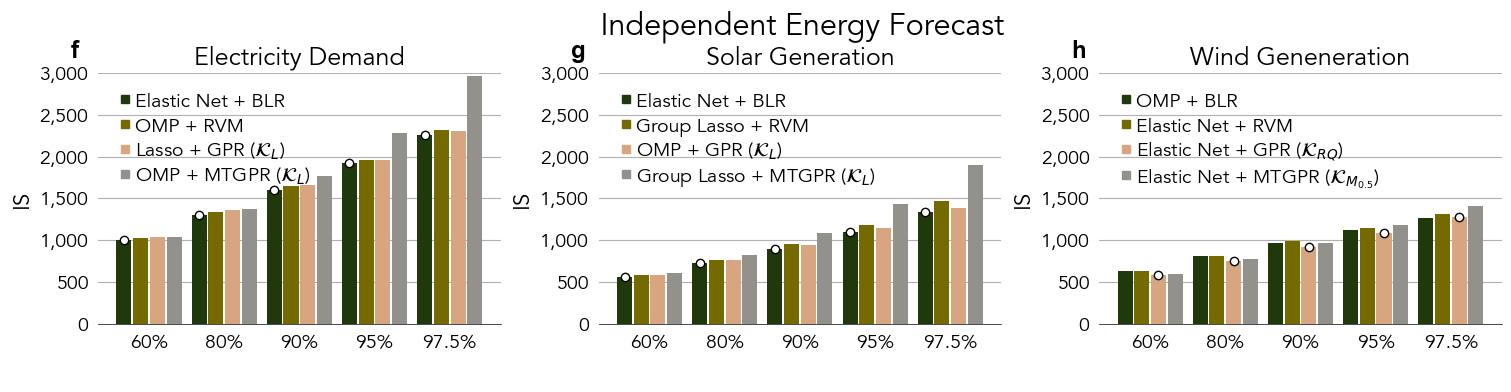

In [44]:
fig, _ax = plt.subplot_mosaic([['f', 'g', 'h']], layout = 'constrained', figsize = (15, 3.5))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")

_plot_interval_scores(_ax['f'], ts_scores_, zones_, colors_3_, resource = 'load', 
                                                               title    = 'Electricity Demand',
                                                               score    = 'IS',
                                                               ylabel   = 'IS',
                                                               xlabel   = ' ',
                                                               legend   = True, 
                                                               y_max    = 3000)

_plot_interval_scores(_ax['g'], ts_scores_, zones_, colors_3_, resource = 'solar', 
                                                               title    = 'Solar Generation',
                                                               xlabel   = ' ',
                                                               score    = 'IS',
                                                               ylabel   = 'IS',
                                                               legend   = True, 
                                                               y_max    = 3000)

_plot_interval_scores(_ax['h'], ts_scores_, zones_, colors_3_, resource = 'wind', 
                                                               title    = 'Wind Geneneration',
                                                               score    = 'IS',
                                                               ylabel   = 'IS',
                                                               xlabel   = ' ',
                                                               legend   = True, 
                                                               y_max    = 3000)


plt.suptitle('           Independent Energy Forecast', fontsize = 22, y = 1.075)

plt.savefig(path_to_images + f'ind_IS.pdf', bbox_inches = 'tight',
                                            dpi         = 300)

plt.show()

## Independent Energy Forecast - Proper Scoring Rules

In [45]:
def _plot_results(ax, ts_scores_, sl_models_, dl_models_, resource, score, criteria, colors_, 
                  s              = 250,
                  units          = 1.,
                  y_min          = 0., 
                  y_max          = 0., 
                  legend_labels_ = [],
                  suptitle       = '', 
                  title          = '', 
                  legend_title   = '', 
                  letter         = '',
                  legend         = False, 
                  decimals       = False):

    width    = 0.15
    offset   = 1.
    markers_ = ['o', 'p', '^', 'd']

    j      = 0
    ticks_ = []
    x_     = np.linspace(0, width*len(sl_models_), len(sl_models_))
    for dl_model in dl_models_:

        i  = 0
        y_ = []
        for sl_model in sl_models_:

            idx_1_ = (ts_scores_['resource'] == resource) & (ts_scores_['score'] == criteria)
            idx_2_ = (ts_scores_['sparse_method'] == sl_model) & (ts_scores_['dense_method'] == dl_model)

            y_.append(ts_scores_.loc[idx_1_ & idx_2_, score].min())
            
            if ts_scores_.loc[idx_1_, score].min() == ts_scores_.loc[idx_1_ & idx_2_, score].min():
                if score == criteria:
                    ax.scatter(x_[i], y_[-1]/units, marker    = markers_[j], 
                                                    s         = s, 
                                                    edgecolor = 'k', 
                                                    lw        = 1., 
                                                    color     = colors_[i], 
                                                    zorder    = 10)
                else:
                    ax.scatter(x_[i], y_[-1]/units, marker    = markers_[j], 
                                                    s         = s, 
                                                    edgecolor = 'w', 
                                                    lw        = .5, 
                                                    color     = colors_[i], 
                                                    zorder    = 10)
            else:
                ax.scatter(x_[i], y_[-1]/units, marker    = markers_[j], 
                                                s         = s/2, 
                                                edgecolor = 'w', 
                                                lw        = .5, 
                                                color     = colors_[i], 
                                                zorder    = 10)

            i +=1 
        ax.plot(x_, y_, lw     = 1., 
                        zorder = 9, 
                        marker = '.', 
                        color  = 'k')
        j += 1
        ticks_.append(x_.mean())
        x_ += offset

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if decimals: ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_ylabel(score, fontsize = 16)
    # plt.xlabel(xlabel, fontsize = 16)
    
    ax.set_xticks(ticks_[:len(dl_models_)], ['BLR', 'RVM', 'GPR', 'MNGPR'], fontsize = 18)
    
    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [.975, .8],
                            frameon        = False)
        ax.add_artist(_leg_1)


    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = None, 
                                    markeredgecolor = 'k', 
                                    markersize      = 4,
                                    label           = 'median',
                                    color           = "None"))

    legend_.append(Line2D([0], [0], marker          = '_', 
                                    markerfacecolor = "silver", 
                                    markeredgecolor = "silver", 
                                    markersize      = 6,
                                    label           = 'mean',
                                    color           = "None"))
    if legend:
        _leg_2 = plt.legend(handles        = legend_, 
                            prop           = {'size': 14}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [0.35, .65],
                            #loc            = 'upper left',
                            frameon        = False)

        ax.add_artist(_leg_2)
    
    ax.grid(axis      = 'y', 
            alpha     = .5, 
            linestyle = '-')
    
def _plot_time(ax, time_, resource, score, colors_, 
               s        = 250,
               suptitle = '', 
               title    = '', 
               legend   = True, 
               y_min    = 1, 
               x_max    = 1):

    markers_       = ['o', 'p', '^', 'd']
    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso']

    idx_1_ = (time_['resource'] == resource) & (time_['score'] == score)

    time_['train'] = time_['train'].astype(float)
    time_['test']  = time_['test'].astype(float)

    i = 0
    for sl_method in time_['sparse_method'].unique():

        idx_2_ = time_['sparse_method'] == sl_method

        j = 0
        for dl_method in time_['dense_method'].unique():

            idx_3_ = time_['dense_method'] == dl_method

            time_p_ = time_.loc[idx_1_ & idx_2_ & idx_3_]

            if j == 0:
                ax.scatter(time_p_['test'], time_p_['train'], s         = s, 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.75,
                                                              facecolor = colors_[i], 
                                                              clip_on   = False)
            else:
                ax.scatter(time_p_['test'], time_p_['train'], s         = s, 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.8,
                                                              facecolor = colors_[i], 
                                                              clip_on   = False)

            j += 1
        i +=1

    ax.spines[['right', 'top']].set_visible(False)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())

    ax.set_ylabel('Training Time (s)', fontsize = 16)
    ax.set_xlabel('Testing Time (s)', fontsize = 16)

    legend_title = "Sparse Learning"

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = "k", 
                                        markersize      = s/15,
                                        markeredgewidth = .5,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = ax.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 14}, 
                            title_fontsize = 16,
                            ncol           = 1, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., .65],
                            frameon        = False)
        ax.add_artist(_leg_1)

    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = 'k', 
                                    markersize      = s/15,
                                    markeredgewidth = .5,
                                    label           = 'BLR'))

    legend_.append(Line2D([0], [0], marker          = 'p', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = s/15,
                                    markeredgewidth = .5,
                                    label           = 'RVM'))

    legend_.append(Line2D([0], [0], marker          = '^', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = s/15,
                                    markeredgewidth = .5,
                                    label           = 'GPR'))

    legend_.append(Line2D([0], [0], marker          = 'd', 
                                    color           = "None",
                                    markerfacecolor = 'None', 
                                    markeredgecolor = "k", 
                                    markersize      = s/15,
                                    markeredgewidth = .5,
                                    label           = 'MNGPR'))

    if legend:
        _leg_2 = ax.legend(handles         = legend_, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 4, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., .125],
                            frameon        = False)
        
        ax.add_artist(_leg_2)

    ax.set_ylim(1, 10000)
    ax.set_xlim(0, x_max)
    
    
def _plot_fs(ax, Scores_, zones_, resource, colors_, 
             score          = 'RMSE',
             legend_labels_ = [], 
             legend_title   = '', 
             ndecimals      = 0,
             xlabel         = '',
             ylabel         = '', 
             legend         = False,
             y_min          = -5, 
             y_max          = 15):
    
    sparse_methods_ = Scores_['sparse_method'].unique()
    dense_methods_  = Scores_['dense_method'].unique()

    width  = 0.4
    offset = 2.
    x_      = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    j       = 0
    ticks_  = []
    values_ = []
    for dense_method in dense_methods_:
        i = 0
        for sparse_method in sparse_methods_:
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['dense_method'] == dense_method)
            idx_2_ = (Scores_['resource'] == resource) & (Scores_['score'] == score)

            p = ax.bar(x_[i], Scores_.loc[idx_1_ & idx_2_, 'FS'].min(), width, color  = colors_[i], 
                                                                               zorder = 9, 
                                                                               align  = 'center')
            if (dense_method == 'GPR') | (dense_method == 'MTGPR'):
                i_kernel = int(ast.literal_eval(Scores_.loc[idx_1_ & idx_2_, 'parameters'].to_list()[0])[-1])
                kernel = f'{kernels_[i_kernel]}'
                print(sparse_method, dense_method, kernel)
                ax.bar_label(p, labels = [f'{x:,.1f}' for x in p.datavalues], size     = 14)
                ax.bar_label(p, labels = [kernel for x in p.datavalues], size = 14, rotation = 90, padding = 17.5)

                                
            else:
                
                ax.bar_label(p, labels = [f'{x:,.1f}' for x in p.datavalues], size     = 14)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
        
    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        ax.legend(handles         = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)

    
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_xticks(ticks_[:len(dense_methods_)], ['BLR', 'RVM', 'GPR', 'MNGPR'], fontsize = 14)

    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

### Independent Electric Load Forecast - Energy Score

lasso GPR $\mathcal{K}_L$
OMP GPR $\mathcal{K}_L$
elastic_net GPR $\mathcal{K}_{RQ}$
group_lasso GPR $\mathcal{K}_{RQ}$
lasso MTGPR $\mathcal{K}_L$
OMP MTGPR $\mathcal{K}_L$
elastic_net MTGPR $\mathcal{K}_L$
group_lasso MTGPR $\mathcal{K}_L$


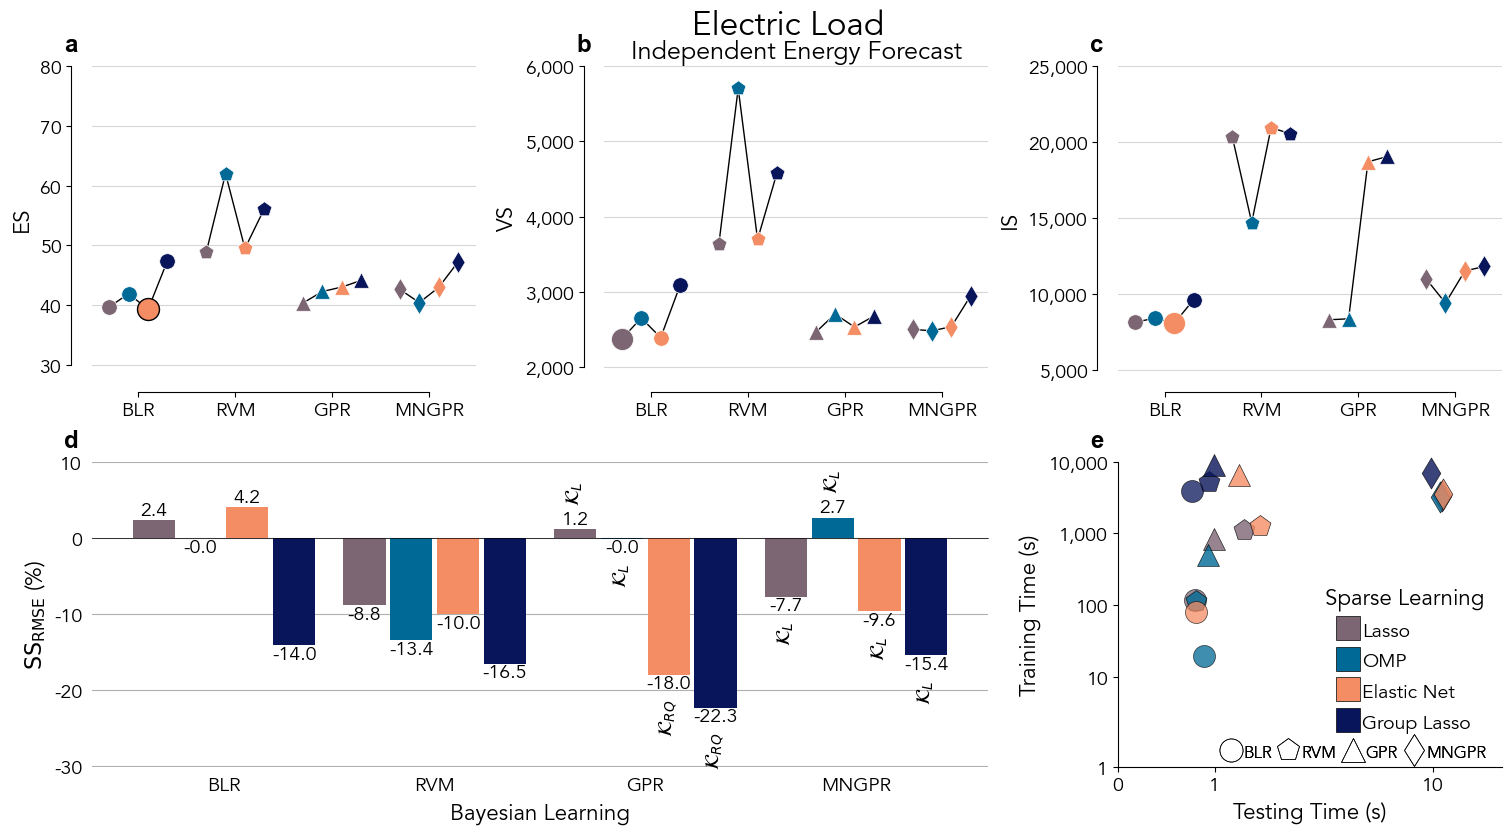

In [46]:
resource = 'load'
criteria = 'ES'
dl_methods_ = ['BLR', 'RVM', 'GPR', 'MTGPR']

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout = 'constrained', figsize = (15, 8))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

_plot_results(_ax['a'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 29, 
                                                              y_max          = 80, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

_ax['b'].set_title('Independent Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 1950, 
                                                              y_max          = 6000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])


_plot_results(_ax['c'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = 4950, 
                                                              y_max          = 25000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)


sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('       Electric Load', fontsize = 24, y = 1.025)


_plot_fs(_ax['d'], ts_scores_, zones_, resource       = resource, 
                                       colors_        = colors_1_, 
                                       score          = criteria,
                                       ndecimals      = 2, 
                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                       xlabel         = 'Bayesian Learning',
                                       ylabel         = r'$\mathrm{SS}_\mathrm{RMSE}$ (%)',
                                       legend_title   = 'Sparse Learning',
                                       legend         = False, 
                                       y_min          = -30.1, 
                                       y_max          = 10.1)

_plot_time(_ax['e'], ts_scores_, resource = resource, 
                                 score    = criteria, 
                                 colors_  = colors_1_, 
                                 legend   = True, 
                                 x_max    = 25)


plt.savefig(path_to_images + f'ind_model_selection_{resource}_{criteria}.pdf', bbox_inches = 'tight',
                                                                               dpi         = 300)

plt.show()

### Independent Solar Generation Forecast - Energy Score

lasso GPR $\mathcal{K}_L$
OMP GPR $\mathcal{K}_L$
elastic_net GPR $\mathcal{K}_L$
group_lasso GPR $\mathcal{K}_L$
lasso MTGPR $\mathcal{K}_L$
OMP MTGPR $\mathcal{K}_L$
elastic_net MTGPR $\mathcal{K}_L$
group_lasso MTGPR $\mathcal{K}_L$


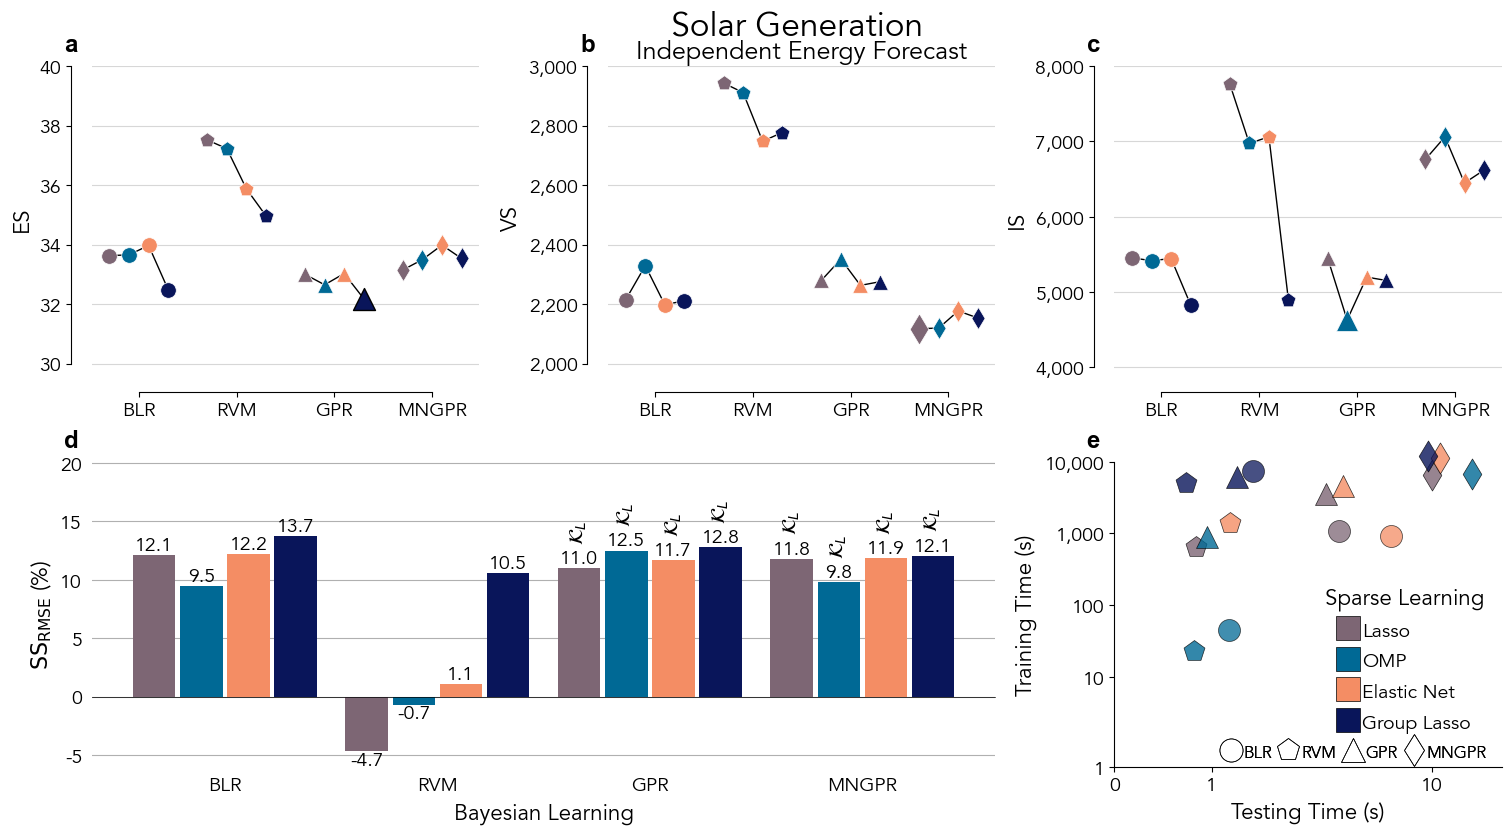

In [47]:
resource = 'solar'
criteria = 'ES'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout = 'constrained', figsize = (15, 8))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

_plot_results(_ax['a'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 29.75, 
                                                              y_max          = 40, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

_ax['b'].set_title('Independent Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 1975, 
                                                              y_max          = 3000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])

_plot_results(_ax['c'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = 3950, 
                                                              y_max          = 8000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('         Solar Generation', fontsize = 24, y = 1.025)

_plot_fs(_ax['d'], ts_scores_, zones_, resource       = resource, 
                                       colors_        = colors_1_, 
                                       score          = criteria,
                                       ndecimals      = 2, 
                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                       xlabel         = 'Bayesian Learning',
                                       ylabel         = r'$\mathrm{SS}_\mathrm{RMSE}$ (%)',
                                       legend_title   = 'Sparse Learning',
                                       legend         = False, 
                                       y_min          = -6, 
                                       y_max          = 20.1)

_plot_time(_ax['e'], ts_scores_, resource = resource, 
                                 score    = criteria, 
                                 colors_  = colors_1_, 
                                 title    = criteria, 
                                 legend   = True, 
                                 x_max    = 25)

plt.savefig(path_to_images + f'ind_model_selection_{resource}_{criteria}.pdf', bbox_inches = 'tight',
                                                                               dpi         = 300)

plt.show()

### Independent Wind Generation Forecast - Energy Score

lasso GPR $\mathcal{K}_{RQ}$
OMP GPR $\mathcal{K}_{RQ}$
elastic_net GPR $\mathcal{K}_{RQ}$
group_lasso GPR $\mathcal{K}_{RQ}$
lasso MTGPR $\mathcal{K}_{M_{1.5}}$
OMP MTGPR $\mathcal{K}_{M_{2.5}}$
elastic_net MTGPR $\mathcal{K}_{M_{1.5}}$
group_lasso MTGPR $\mathcal{K}_{M_{1.5}}$


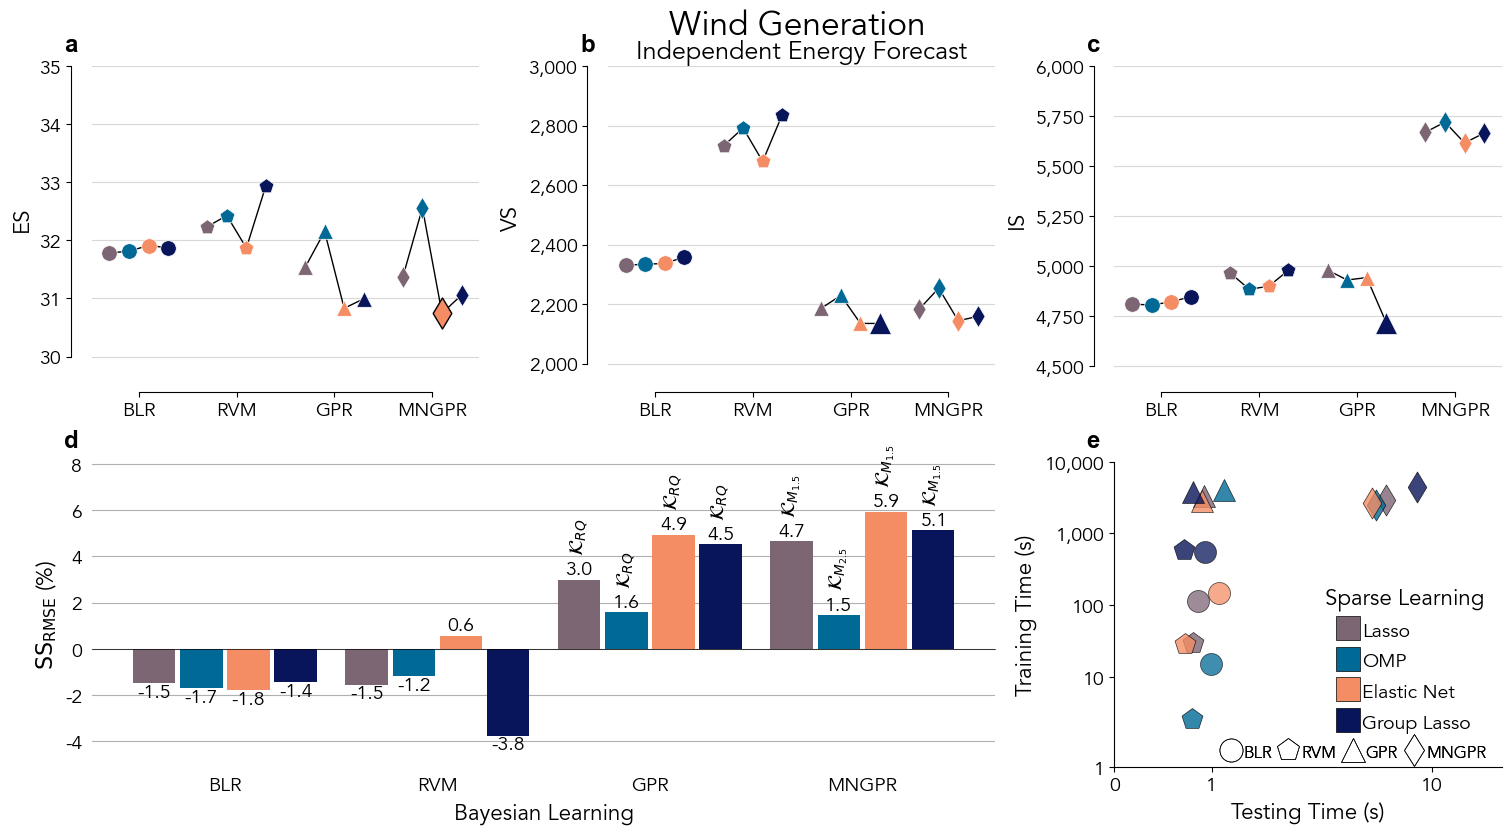

In [48]:
resource = 'wind'
criteria = 'ES'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout = 'constrained', figsize = (15, 8))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

_plot_results(_ax['a'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 29.75, 
                                                              y_max          = 35, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

_ax['b'].set_title('Independent Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 1975, 
                                                              y_max          = 3000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])

_plot_results(_ax['c'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = 4475, 
                                                              y_max          = 6000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('         Wind Generation', fontsize = 24, y = 1.025)

_plot_fs(_ax['d'], ts_scores_, zones_, resource       = resource, 
                                       colors_        = colors_1_, 
                                       score          = criteria,
                                       ndecimals      = 2, 
                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                       xlabel         = 'Bayesian Learning',
                                       ylabel         = r'$\mathrm{SS}_\mathrm{RMSE}$ (%)',
                                       legend_title   = 'Sparse Learning',
                                       legend         = False, 
                                       y_min          = -5.1, 
                                       y_max          = 8.1)

_plot_time(_ax['e'], ts_scores_, resource = resource, 
                                 score    = criteria, 
                                 colors_  = colors_1_, 
                                 title    = criteria, 
                                 legend   = True, 
                                 x_max    = 25)

plt.savefig(path_to_images + f'ind_model_selection_{resource}_{criteria}.pdf', bbox_inches = 'tight',
                                                                               dpi         = 300)

plt.show()

In [58]:
def _plot_time(ax, time_, resource, score, colors_, 
               s        = 250,
               ylabel   = 'Training Time (s)', 
               legend_1 = True, 
               legend_2 = True, 
               y_min    = 1, 
               x_max    = 1):

    markers_       = ['o', 'p', '^', 'd']
    legend_labels_ = ['Lasso', 'OMP', 'EN', 'GL']

    idx_1_ = (time_['resource'] == resource) & (time_['score'] == score)

    time_['train'] = time_['train'].astype(float)
    time_['test']  = time_['test'].astype(float)

    i = 0
    for sl_method in time_['sparse_method'].unique():

        idx_2_ = time_['sparse_method'] == sl_method

        j = 0
        for dl_method in time_['dense_method'].unique():

            idx_3_ = time_['dense_method'] == dl_method

            time_p_ = time_.loc[idx_1_ & idx_2_ & idx_3_]

            if j == 0:
                ax.scatter(time_p_['test'], time_p_['train'], s         = s, 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.75,
                                                              facecolor = colors_[i], 
                                                              clip_on   = False)
            else:
                ax.scatter(time_p_['test'], time_p_['train'], s         = s, 
                                                              marker    = markers_[j], 
                                                              edgecolor = 'k',
                                                              lw        = .5, 
                                                              alpha     = 0.8,
                                                              facecolor = colors_[i], 
                                                              clip_on   = False)

            j += 1
        i +=1

    ax.spines[['right', 'top']].set_visible(False)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())

    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel('Testing Time (s)', fontsize = 16)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = "k", 
                                        markersize      = s/20,
                                        markeredgewidth = .5,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend_1:
        _leg_1 = ax.legend(handles        = legend_, 
                           title          = "Sparse Learning", 
                           prop           = {'size': 16}, 
                           title_fontsize = 18,
                           ncol           = 4, 
                           columnspacing  = 0.5, 
                           handletextpad  = 0.5,
                           labelspacing   = 0.5,
                           bbox_to_anchor = [1.05, -.2],
                           frameon        = False)
        ax.add_artist(_leg_1)

    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = 'k', 
                                    markersize      = s/19,
                                    markeredgewidth = .5,
                                    label           = 'BLR'))

    legend_.append(Line2D([0], [0], marker          = 'p', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = s/18,
                                    markeredgewidth = .5,
                                    label           = 'RVM'))

    legend_.append(Line2D([0], [0], marker          = '^', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = s/20,
                                    markeredgewidth = .5,
                                    label           = 'GPR'))

    legend_.append(Line2D([0], [0], marker          = 'd', 
                                    color           = "None",
                                    markerfacecolor = 'None', 
                                    markeredgecolor = "k", 
                                    markersize      = s/21,
                                    markeredgewidth = .5,
                                    label           = 'SLGPR'))

    if legend_2:
        _leg_2 = ax.legend(handles         = legend_, 
                           title          = "Bayesian Learning", 
                           prop           = {'size': 16}, 
                           title_fontsize = 18,
                           ncol           = 4, 
                           columnspacing  = 0.5, 
                           handletextpad  = 0.5,  
                           labelspacing   = 0.5,
                           bbox_to_anchor = [0.875, -.2],
                           frameon        = False)
        
        ax.add_artist(_leg_2)

    ax.set_ylim(1, 10000)
    ax.set_xlim(0, x_max)
    
def _plot_fs(ax, Scores_, zones_, resource, colors_, 
             score          = 'RMSE',
             legend_labels_ = [], 
             legend_title   = '', 
             ndecimals      = 0,
             xlabel         = '',
             ylabel         = '', 
             legend         = False,
             y_min          = -5, 
             y_max          = 15):
    
    sparse_methods_ = Scores_['sparse_method'].unique()
    dense_methods_  = Scores_['dense_method'].unique()

    width  = 0.4
    offset = 2.125
    x_      = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    j       = 0
    ticks_  = []
    values_ = []
    for dense_method in dense_methods_:
        i = 0
        for sparse_method in sparse_methods_:
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['dense_method'] == dense_method)
            idx_2_ = (Scores_['resource'] == resource) & (Scores_['score'] == score)

            # if (dense_method == 'GPR') | (dense_method == 'MTGPR'):
            #     i_kernel = int(ast.literal_eval(Scores_.loc[idx_1_ & idx_2_, 'parameters'].to_list()[0])[-1])
            #     kernel = f' ({kernels_[i_kernel]})'
            #     print(sparse_method, dense_method, kernel)
            #print('fs', sparse_method, dense_method, Scores_.loc[idx_1_ & idx_2_, 'FS'].min())
            p = ax.bar(x_[i], Scores_.loc[idx_1_ & idx_2_, 'FS'].min(), width, color  = colors_[i], 
                                                                               zorder = 9, 
                                                                               align  = 'center')
                
                
            if (dense_method == 'GPR') | (dense_method == 'MTGPR'):
                i_kernel = int(ast.literal_eval(Scores_.loc[idx_1_ & idx_2_, 'parameters'].to_list()[0])[-1])
                kernel = f'{kernels_[i_kernel]}'
                ax.bar_label(p, labels = [kernel], size     = 12, 
                                                   rotation = 90, padding = 1.)
                
            # ax.bar_label(p, labels = [f'{ x:,.2f}' for x in p.datavalues], size     = 12.5,
            #                                                                rotation = 0)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
        
    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        ax.legend(handles         = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)

    
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['top', 'left','right', 'bottom']].set_visible(False)
    
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xticks(ticks_[:len(dense_methods_)], ['BLR', 'RVM', 'GPR', 'SLGPR'], fontsize = 14)

    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)
    
def _plot_results(ax, ts_scores_, sl_models_, dl_models_, resource, score, criteria, colors_, 
                  s            = 250,
                  units        = 1.,
                  y_min        = 0., 
                  y_max        = 0., 
                  legend_labels_ = [],
                  decimals = False,
                  legend_title = '', 
                  ylabel       = '',
                  legend       = False):

    width    = 0.15
    offset   = 1.
    markers_ = ['o', 'p', '^', 'd']

    j      = 0
    ticks_ = []
    x_     = np.linspace(0, width*len(sl_models_), len(sl_models_))
    for dl_model in dl_models_:

        i  = 0
        y_ = []
        for sl_model in sl_models_:

            idx_1_ = (ts_scores_['resource'] == resource) & (ts_scores_['score'] == criteria)
            idx_2_ = (ts_scores_['sparse_method'] == sl_model) & (ts_scores_['dense_method'] == dl_model)

            y_.append(ts_scores_.loc[idx_1_ & idx_2_, score].min())
            #print(score, sl_model, dl_model, y_[-1]/units)
            if ts_scores_.loc[idx_1_, score].min() == ts_scores_.loc[idx_1_ & idx_2_, score].min():
                if score == criteria:
                    ax.scatter(x_[i], y_[-1]/units, marker    = markers_[j], 
                                                    s         = s, 
                                                    edgecolor = 'k', 
                                                    lw        = 1., 
                                                    color     = colors_[i], 
                                                    zorder    = 10)
                else:
                    ax.scatter(x_[i], y_[-1]/units, marker    = markers_[j], 
                                                    s         = s, 
                                                    edgecolor = 'w', 
                                                    lw        = .5, 
                                                    color     = colors_[i], 
                                                    zorder    = 10)
            else:
                ax.scatter(x_[i], y_[-1]/units, marker    = markers_[j], 
                                                s         = s/2, 
                                                edgecolor = 'w', 
                                                lw        = .5, 
                                                color     = colors_[i], 
                                                zorder    = 10)

            i +=1 
        # ax.plot(x_, y_, lw     = 1., 
        #                 zorder = 9, 
        #                 marker = '.', 
        #                 color  = 'k')
        j += 1
        ticks_.append(x_.mean())
        x_ += offset

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if decimals: ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_ylabel(ylabel, fontsize = 16)
    # plt.xlabel(xlabel, fontsize = 16)

    ax.set_xticks(ticks_[:len(dl_models_)], ['BLR', 'RVM', 'GPR', 'SLGPR'], fontsize = 18)

    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [.975, .8],
                            frameon        = False)
        ax.add_artist(_leg_1)


    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = None, 
                                    markeredgecolor = 'k', 
                                    markersize      = 4,
                                    label           = 'median',
                                    color           = "None"))

    legend_.append(Line2D([0], [0], marker          = '_', 
                                    markerfacecolor = "silver", 
                                    markeredgecolor = "silver", 
                                    markersize      = 6,
                                    label           = 'mean',
                                    color           = "None"))
    if legend:
        _leg_2 = plt.legend(handles        = legend_, 
                            prop           = {'size': 14}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [0.35, .65],
                            #loc            = 'upper left',
                            frameon        = False)

        ax.add_artist(_leg_2)
    
    ax.grid(axis      = 'y', 
            alpha     = .5, 
            linestyle = '-')

load
solar
wind


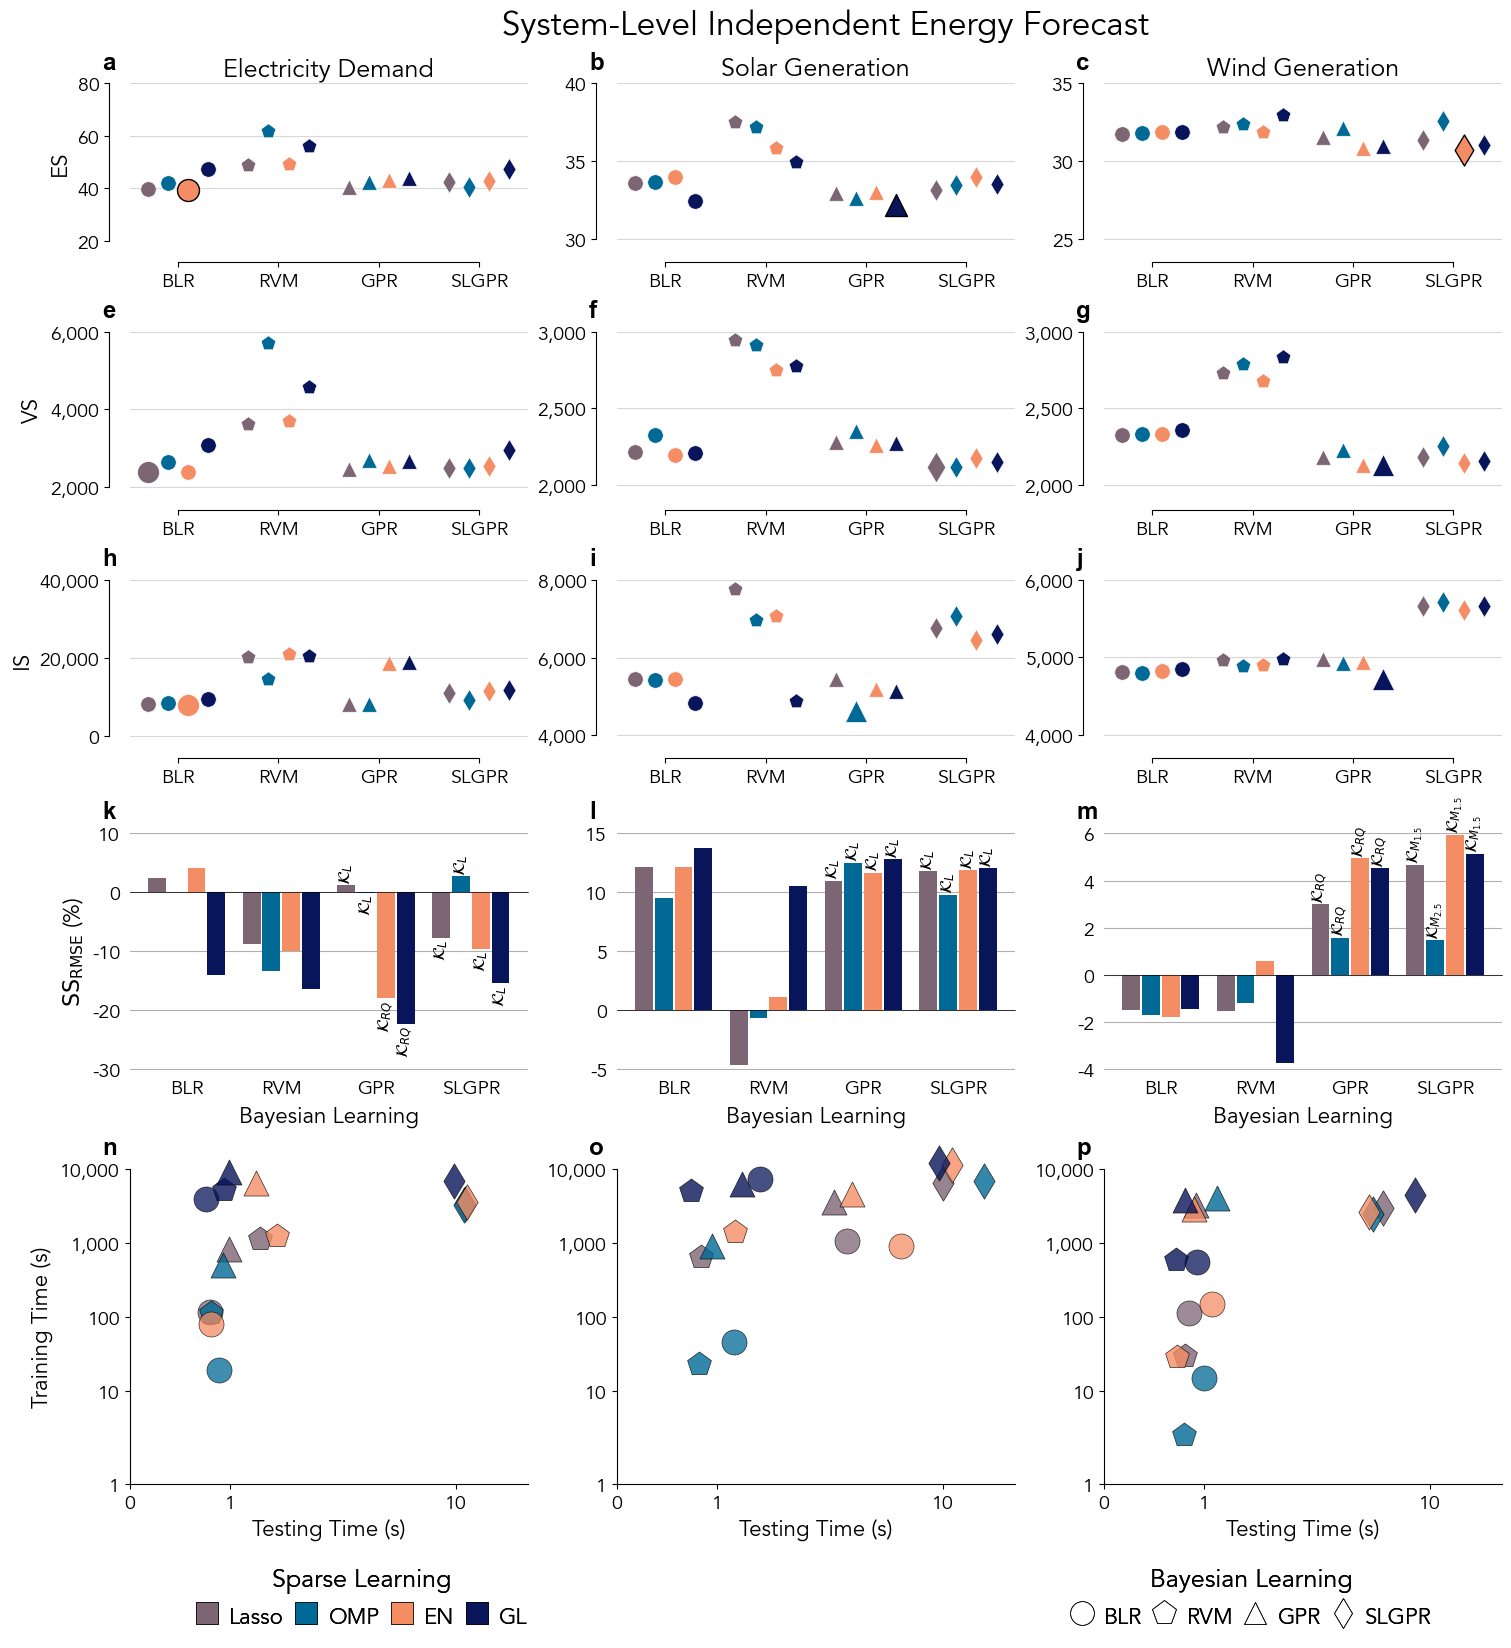

In [60]:
resource = 'load'
criteria = 'ES'
print(resource)

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], 
                               ['e', 'f', 'g'],
                               ['h', 'i', 'j'],
                               ['k', 'l', 'm'], 
                               ['n', 'o', 'p']], layout      = 'constrained', 
                                                 figsize     = (15, 15), 
                                                 gridspec_kw = {'height_ratios': [1, 1, 1, 1.5, 2]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

_ax['a'].set_title('Electricity Demand', fontsize = 18, y = 1.)

_plot_results(_ax['a'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 20., 
                                                              y_max          = 80., 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              ylabel         = 'ES',
                                                              s              = 250)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['a'])

_plot_results(_ax['e'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 1950, 
                                                              y_max          = 6000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              ylabel         = 'VS',
                                                              s              = 250)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['e'])


_plot_results(_ax['h'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = -250, 
                                                              y_max          = 40000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              ylabel         = 'IS',
                                                              s              = 250)


sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['h'])

_plot_fs(_ax['k'], ts_scores_, zones_, resource       = resource, 
                                       colors_        = colors_1_, 
                                       score          = criteria,
                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                       xlabel         = 'Bayesian Learning',
                                       ylabel         = r'$\mathrm{SS}_{\mathrm{RMSE}}$ (%)',
                                       legend_title   = 'Sparse Learning',
                                       legend         = False, 
                                       y_min          = -30.1, 
                                       y_max          = 10.05)

_plot_time(_ax['n'], ts_scores_, resource = resource, 
                                 score    = criteria, 
                                 colors_  = colors_1_, 
                                 legend_2 = False, 
                                 x_max    = 25, 
                                 s        = 325)

resource = 'solar'
print(resource)

_ax['b'].set_title('Solar Generation', fontsize = 18, y = 1.)

_plot_results(_ax['b'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 29.9, 
                                                              y_max          = 40, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              ylabel         = '',
                                                              s              = 250)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['b'])

_plot_results(_ax['f'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 1975, 
                                                              y_max          = 3000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              ylabel         = '',
                                                              s              = 250)

sns.despine(trim   = True,
            offset = 15, 
            ax     = _ax['f'])

_plot_results(_ax['i'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = 3950, 
                                                              y_max          = 8000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              ylabel         = '',
                                                              s              = 250)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['i'])


_plot_fs(_ax['l'], ts_scores_, zones_, resource       = resource, 
                                       colors_        = colors_1_, 
                                       score          = criteria,
                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                       xlabel         = 'Bayesian Learning',
                                       ylabel         = '',
                                       legend_title   = 'Sparse Learning',
                                       legend         = False, 
                                       y_min          = -5.02, 
                                       y_max          = 15.01)

_plot_time(_ax['o'], ts_scores_, resource = resource, 
                                 score    = criteria, 
                                 colors_  = colors_1_, 
                                 ylabel   = '', 
                                 legend_2 = False, 
                                 legend_1 = False, 
                                 x_max    = 25, 
                                 s        = 325)


resource = 'wind'
print(resource)
_ax['c'].set_title('Wind Generation', fontsize = 18, y = 1)

_plot_results(_ax['c'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'ES', 
                                                              y_min          = 24.9, 
                                                              y_max          = 35, 
                                                              decimals       = False,
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              ylabel         = '',
                                                              s              = 250)


sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['c'])

_plot_results(_ax['g'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'VS', 
                                                              y_min          = 1975, 
                                                              y_max          = 3000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              ylabel         = '',
                                                              s              = 250)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['g'])

_plot_results(_ax['j'], ts_scores_, sl_methods_, dl_methods_, resource       = resource, 
                                                              criteria       = criteria,
                                                              score          = 'IS', 
                                                              y_min          = 3970, 
                                                              y_max          = 6000, 
                                                              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                              colors_        = colors_1_,
                                                              legend_title   = 'Sparse Learning', 
                                                              legend         = False, 
                                                              ylabel         = '',
                                                              s              = 250)

sns.despine(trim   = True, 
            offset = 15, 
            ax     = _ax['j'])

_plot_fs(_ax['m'], ts_scores_, zones_, resource       = resource, 
                                       colors_        = colors_1_, 
                                       score          = criteria,
                                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                                       xlabel         = 'Bayesian Learning',
                                       ylabel         = '',
                                       legend_title   = 'Sparse Learning',
                                       legend         = False, 
                                       y_min          = -4.01, 
                                       y_max          = 6.01)

_plot_time(_ax['p'], ts_scores_, resource = resource, 
                                 score    = criteria, 
                                 colors_  = colors_1_, 
                                 ylabel   =  '', 
                                 legend_1 = False, 
                                 x_max    = 25,
                                 s        = 325)


#plt.suptitle('               Independent Energy Forecast', fontsize = 22, y = 1.025)
plt.suptitle('               System-Level Independent Energy Forecast', fontsize = 24, y = 1.025)

plt.savefig(path_to_images + f'ind_model_selection_{criteria}.pdf', bbox_inches = 'tight',
                                                                    dpi         = 300)

plt.show()

# Joint Energy Forecast Model Selection

## Load Joint Energy Forecast Results

In [35]:
def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

# Energy Score across time
def _ES(Y_, Y_hat_):

    N_observation, N_tasks, N_horizons, N_scen = Y_hat_.shape

    score_ = np.zeros((N_observation))
    Y_     = np.concatenate([Y_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    Y_hat_ = np.concatenate([Y_hat_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)

    for n in range(N_observation):
        Y_p_   = np.tile(Y_[n, :], (N_scen, 1)).T
        frac1_ = np.sqrt(np.diag((Y_hat_[n, :, :] - Y_p_).T @ (Y_hat_[n, :, :] - Y_p_)))
        frac2_ = 0
        for m in range(N_scen):
            frac2_ += np.sqrt(np.sum((Y_hat_[n, :, :].T - Y_hat_[n, :, m])**2, axis = 1))
        score_[n] = (np.sum(frac1_)/N_scen) - (np.sum(frac2_)/(2*(N_scen**2)))
    return score_

# Variogram Score computed across temporal dimensions
def _VS(Y_, Y_hat_, p = .5):
    N_observation, N_tasks, N_horizons, N_scen = Y_hat_.shape
    score_ = np.zeros((N_observation))
    Y_     = np.concatenate([Y_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    Y_hat_ = np.concatenate([Y_hat_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    for n in range(N_observation):
        frac1_ = np.absolute(np.subtract.outer(Y_[n, ], Y_[n, :]))**p
        frac2_ = np.zeros((N_horizons*N_tasks, N_horizons*N_tasks))
        for m in range(N_scen):
            frac2_ += np.absolute(np.subtract.outer(Y_hat_[n, :, m], Y_hat_[n, :, m]))**p
        score_[n] = np.sum((frac1_ - (frac2_/N_scen))**2)
    return score_

def _IS(Y_, M_, S2_, z, alpha):
    
    # Interval Score
    def __IS(y_, alpha, lower_, upper_):
        score_  = (upper_ - lower_)
        score_ += (2./alpha)*(lower_ - y_) * (1*(y_ < lower_))
        score_ += (2./alpha)*(y_ - upper_) * (1*(y_ > upper_))
        return score_
    # 95% CI: z = 1.96; alpha = 0.05
    # 90% CI: z = 1.645; alpha = 0.1
    N_observation, N_horizons = M_.shape
    # Y_     = np.concatenate([Y_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # M_     = np.concatenate([M_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # S2_    = np.concatenate([S2_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    score_ = np.zeros((N_observation,))
    for n in range(N_observation):
        score_[n] = __IS(Y_[n, :], alpha, lower_ = M_[n, :] - z*np.sqrt(S2_[n, :]),
                                          upper_ = M_[n, :] + z*np.sqrt(S2_[n, :])).sum()
    return score_

def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

def _load_test_scores(zones_, sl_methods_, dl_methods_, scores_, path):
    
    df_ = []
    
    param_ = pd.read_csv(path + 'prob_model_selection_multisource.csv')

    for zone, N_resources in zip(zones_, [3, 3, 2]):
        print(zone)
        for score in scores_:
            for sl_method in sl_methods_:
                for dl_method in dl_methods_:
                    
                    with open(path + '{}-{}-{}-{}.pkl'.format(zone, sl_method, dl_method, score), 'rb') as f:
                        _model = pickle.load(f)  
                        
                    idx_   = (param_['sparse_method'] == sl_method) & (param_['dense_method'] == dl_method)
                    idx_   = idx_ & (param_['score'] == score) & (param_['resource'] == zone)
                    thetas = param_.loc[idx_ , 'parameters'].tolist()[0]

                    N_samples, N_tasks, N_horizons = _model['mean'].shape
                    Z = N_samples*N_tasks*N_horizons
                    
                    Y_      = _model['targets'][:, 0, :] 
                    Y_iso_  = _model['caiso'][:, 0, :] 
                    Y_mean_ = _model['mean'][:, 0, :]
                    Y_var_  = _model['variance'][:, 0, :]
                    for i_resource in range(N_resources - 1):
                        Y_      -= _model['targets'][:, i_resource + 1, :] 
                        Y_iso_  -= _model['caiso'][:, i_resource + 1, :] 
                        Y_mean_ -= _model['mean'][:, i_resource + 1, :] 
                        Y_var_  += _model['variance'][:, i_resource + 1, :] 

                    tr = _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
                    ts = (_model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time'])/N_samples
                    
                    IS975 = _IS(Y_, Y_mean_, Y_var_, z = 2.243, alpha = 0.025).sum()/Z
                    IS95  = _IS(Y_, Y_mean_, Y_var_, z = 1.959, alpha = 0.05).sum()/Z
                    IS90  = _IS(Y_, Y_mean_, Y_var_, z = 1.645, alpha = 0.1).sum()/Z
                    IS80  = _IS(Y_, Y_mean_, Y_var_, z = 1.282, alpha = 0.2).sum()/Z
                    IS60  = _IS(Y_, Y_mean_, Y_var_, z = 0.842, alpha = 0.4).sum()/Z

                    #LogS = -z_.sum()/Z
                    RMSE = _RMSE(Y_, Y_mean_).mean()
                    FS   = 100*(1. - _RMSE(Y_, Y_mean_).sum()/_RMSE(Y_, Y_iso_).sum())
                    ES   = _ES(_model['targets'], _model['samples']).sum()/Z
                    VS   = _VS(_model['targets'], _model['samples']).sum()/Z
                    IS   = IS60 + IS80 + IS90 + IS95 + IS975 

                    df_.append([sl_method, dl_method, thetas, zone, score, RMSE, FS, ES, VS, IS, IS60, IS80, IS90, IS95, IS975, tr, ts])

    return pd.DataFrame(df_, columns = ['sparse_method', 'dense_method', 'parameters', 'zone', 'score', 'RMSE', 'FS', 'ES', 'VS', 'IS', 'IS60', 'IS80', 'IS90','IS95', 'IS975', 'train', 'test'])

path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-4/'

resources_  = ['load', 'solar', 'wind']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
dl_methods_ = ['MTGPR']
zones_      = ['NP15', 'SP15', 'ZP26']
scores_     = ['ES', 'VS', 'IS']

jt_ts_scores_ = _load_test_scores(zones_, sl_methods_, dl_methods_, scores_, path_to_mdls)

jt_ts_scores_['RMSE']  = jt_ts_scores_['RMSE'].astype(float)
jt_ts_scores_['FS']    = jt_ts_scores_['FS'].astype(float)
jt_ts_scores_['ES']    = jt_ts_scores_['ES'].astype(float)
jt_ts_scores_['VS']    = jt_ts_scores_['VS'].astype(float)
jt_ts_scores_['IS']    = jt_ts_scores_['IS'].astype(float)
jt_ts_scores_['IS60']  = jt_ts_scores_['IS60'].astype(float)
jt_ts_scores_['IS80']  = jt_ts_scores_['IS80'].astype(float)
jt_ts_scores_['IS90']  = jt_ts_scores_['IS90'].astype(float)
jt_ts_scores_['IS95']  = jt_ts_scores_['IS95'].astype(float)
jt_ts_scores_['IS975'] = jt_ts_scores_['IS975'].astype(float)
jt_ts_scores_['train'] = jt_ts_scores_['train'].astype(float)
jt_ts_scores_['test']  = jt_ts_scores_['test'].astype(float)

NP15
SP15
ZP26


## Joint Energy Nodel-Level Forecast - Interval Score

In [36]:
def _plot_interval_scores(ax, Scores_, colors_, zone,
                          legend_labels_ = [], 
                          legend_title   = '', 
                          score          = '', 
                          xlabel         = 'Confidence Interval',
                          ylabel         = '', 
                          title          = '', 
                          y_max          = 5000.,
                          legend         = False):
    
    interval_scores_ = ['IS60','IS80','IS90','IS95', 'IS975']
    dense_methods_  = Scores_['dense_method'].unique()
    sparse_methods_ = Scores_['sparse_method'].unique()
    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    ax.set_title(title, size = 18)
    width  = 0.4
    offset = 2.

    ticks_  = []
    values_ = []
    j = 0
    for interval_score in interval_scores_:
        i = 0
        kernel_ = []
        for sparse_method in sparse_methods_:
     
            idx_1_ = (Scores_['zone'] == zone) & (Scores_['score'] == 'IS') & (Scores_['sparse_method'] == sparse_method)
     
            df_      = Scores_.loc[idx_1_ & (Scores_['IS'] == Scores_.loc[idx_1_, 'IS'].min())]
            i_kernel = int(ast.literal_eval(df_['parameters'].to_list()[0])[-1][-1])
            kernel   = f' ({kernels_[i_kernel]})'
            
            kernel_.append(kernel)
                
            p = ax.bar(x_[i], Scores_.loc[idx_1_, interval_score].min(), width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
            if Scores_.loc[idx_1_, 'IS'].min() == Scores_.loc[(Scores_['zone'] == zone) & (Scores_['score'] == score), 'IS'].min():
                ax.scatter(x_[i], Scores_.loc[idx_1_, interval_score].min(), marker   = 'o', 
                                                                             color     = 'w', 
                                                                             edgecolor = 'k', 
                                                                             lw        = 1., 
                                                                             zorder    = 10)

            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    ax.set_xticks(ticks_[:len(interval_scores_)], ['60%', '80%', '90%', '95%', '97.5%'], fontsize = 10)
    
    ax.set_ylim(0, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i] + kernel_[i],
                                        color           = "None"))
    if legend:
        ax.legend(handles        = legend_, 
                  title          = legend_title, 
                  prop           = {'size': 14}, 
                  title_fontsize = 16,
                  ncol           = 1, 
                  columnspacing  = 0., 
                  handletextpad  = 0.,  
                  #bbox_to_anchor = [1., .825],
                  loc = "upper left",
                  labelspacing = .2,
                  frameon        = False)

    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        
    ax.set_ylabel('IS', fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

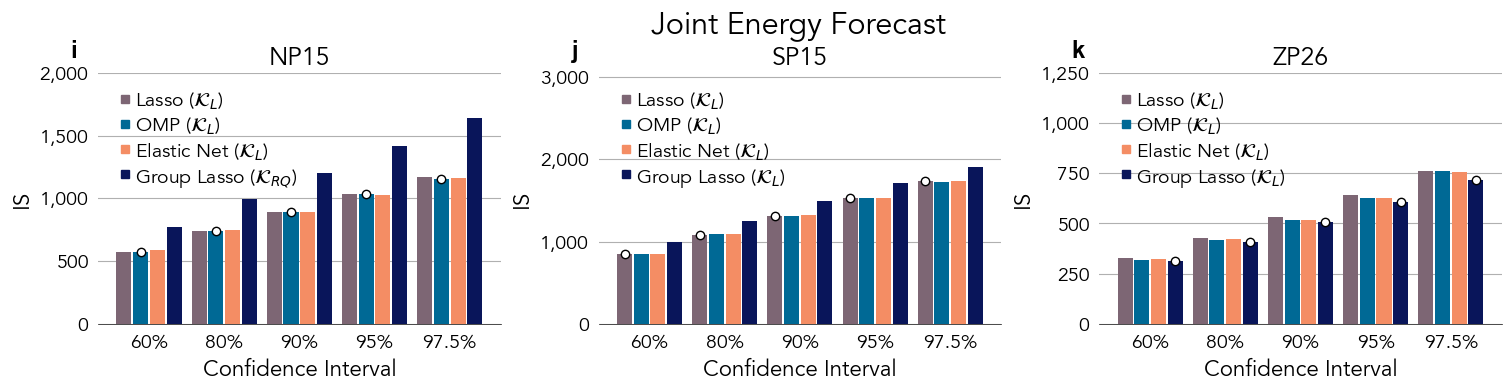

In [37]:
fig, _ax = plt.subplot_mosaic([['i', 'j', 'k']], layout = 'constrained', figsize = (15, 3.5))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")
    
_plot_interval_scores(_ax['i'], jt_ts_scores_, colors_1_, 
                      zone            = 'NP15', 
                      legend_labels_  = ['Lasso','OMP','Elastic Net', 'Group Lasso'], 
                      score           = 'IS',
                      title           = 'NP15',
                      legend          = True, 
                      y_max           = 2000)

_plot_interval_scores(_ax['j'], jt_ts_scores_, colors_1_, 
                      zone            = 'SP15', 
                      legend_labels_  = ['Lasso','OMP','Elastic Net', 'Group Lasso'], 
                      score           = 'IS',
                      title           = 'SP15',
                      legend          = True, 
                      y_max           = 3050)


_plot_interval_scores(_ax['k'], jt_ts_scores_, colors_1_, 
                      zone            = 'ZP26', 
                      legend_labels_  = ['Lasso','OMP','Elastic Net', 'Group Lasso'], 
                      score           = 'IS',
                      title           = 'ZP26',
                      legend          = True, 
                      y_max           = 1250)

plt.suptitle('          Joint Energy Forecast', fontsize = 22, y = 1.075)

plt.savefig(path_to_images + f'jt_IS.pdf', bbox_inches = 'tight',
                                            dpi         = 300)

plt.show()

### Joint Energy Node-Level Forecast 

In [38]:
def _plot_results(ax, ts_scores_, sl_models_, zones_, score, criteria, colors_, 
                  units        = 1.,
                  y_min        = 0., 
                  y_max        = 0., 
                  legend_labels_ = [],
                  suptitle     = '', 
                  title        = '', 
                  legend_title = '', 
                  letter       = '',
                  legend       = False, 
                  decimals     = False):

    #markers_  = ['o', 'p', '^',]
    markers_ = ['D', '8', 'h']

    width  = 0.15
    offset = 1.

    x_ = np.linspace(0, width*len(sl_models_), len(sl_models_))

    ticks_ = []
    j = 0
    dl_model = 'MTGPR'
    for zone in zones_:

        i = 0
        y_ = []
        for sl_model in sl_models_:

            idx_1_ = (ts_scores_['zone'] == zone) & (ts_scores_['score'] == criteria)
            idx_2_ = (ts_scores_['sparse_method'] == sl_model) & (ts_scores_['dense_method'] == dl_model)

            y_.append(ts_scores_.loc[idx_1_ & idx_2_, score].min())
            print(score, zone, sl_model, ts_scores_.loc[idx_1_ & idx_2_, score].min())

            if ts_scores_.loc[idx_1_, score].min() == ts_scores_.loc[idx_1_ & idx_2_, score].min():
                if score == criteria:
                    ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 250, edgecolor = 'k', lw = 1., color = colors_[i], zorder = 10)
                else:
                    ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 250, edgecolor = 'w', lw = .5, color = colors_[i], zorder = 10)
            else:
                ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 150, edgecolor = 'w', lw = .5, color = colors_[i], zorder = 10)

            i +=1 
        ax.plot(x_, y_, lw = 1., zorder = 9, marker = '.', color = 'k')
        j += 1
        ticks_.append(x_.mean())
        x_ += offset

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if decimals: ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_ylabel(score, fontsize = 16)

    ax.set_xticks(ticks_[:len(zones_)], zones_, fontsize = 18)

    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [.975, .8],
                            frameon        = False)
        ax.add_artist(_leg_1)


    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = None, 
                                    markeredgecolor = 'k', 
                                    markersize      = 4,
                                    label           = 'median',
                                    color           = "None"))

    legend_.append(Line2D([0], [0], marker          = '_', 
                                    markerfacecolor = "silver", 
                                    markeredgecolor = "silver", 
                                    markersize      = 6,
                                    label           = 'mean',
                                    color           = "None"))
    if legend:
        _leg_2 = plt.legend(handles        = legend_, 
                            prop           = {'size': 14}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [0.35, .65],
                            #loc            = 'upper left',
                            frameon        = False)

        ax.add_artist(_leg_2)
    
    ax.grid(axis      = 'y', 
            alpha     = .5, 
            linestyle = '-')
    
def _plot_time(ax, time_, score, colors_, legend, 
               y_min = 1, 
               x_max = 1):

    #markers_       = ['o', 'p', '^', 'd']
    markers_       = ['D', '8', 'h']
    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso']

    idx_1_ = time_['score'] == score

    time_['train'] = time_['train'].astype(float)
    time_['test']  = time_['test'].astype(float)


    i = 0
    for sl_method in time_['sparse_method'].unique():

        idx_2_ = time_['sparse_method'] == sl_method

        j = 0
        for resource in time_['zone'].unique():

            idx_3_  = time_['zone'] == resource
            time_p_ = time_.loc[idx_1_ & idx_2_ & idx_3_]

            ax.scatter(time_p_['test'], time_p_['train'], s         = 300., 
                                                          marker    = markers_[j], 
                                                          edgecolor = 'k',
                                                          lw        = .5, 
                                                          alpha     = 0.6,
                                                          facecolor = colors_[i], clip_on = False)

            j += 1
        i +=1

    ax.spines[['right', 'top']].set_visible(False)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())

    ax.set_ylabel('Training Time (s)', fontsize = 16)
    ax.set_xlabel('Testing Time (s)', fontsize = 16)


    legend_title = "Sparse Learning"

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = "k", 
                                        markersize      = 10,
                                        markeredgewidth = .5,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 14}, 
                            title_fontsize = 16,
                            ncol           = 1, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.5,  
                            bbox_to_anchor = [.5, .65],
                            frameon        = False)
        ax.add_artist(_leg_1)

    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'D', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = 'k', 
                                    markersize      = 12,
                                    markeredgewidth = .5,
                                    label           = 'NP15'))

    legend_.append(Line2D([0], [0], marker          = '8', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 15,
                                    markeredgewidth = .5,
                                    label           = 'SP15'))

    legend_.append(Line2D([0], [0], marker          = 'h', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 15,
                                    markeredgewidth = .5,
                                    label           = 'ZP26'))
    
    ax.set_ylim(1000, 100000)
    ax.set_xlim(1, x_max)

    if legend:
        _leg_2 = ax.legend(handles        = legend_, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 4, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., .125],
                            frameon        = False)
        ax.add_artist(_leg_2)
        
        
def _plot_node_fs(ax, Scores_, zones_, colors_, 
                  legend_labels_ = [], 
                  legend_title   = '', 
                  score          = 'RMSE',
                  xlabel         = '',
                  ylabel         = '', 
                  legend         = False, 
                  y_min          = -20, 
                  y_max          = 20):
    
    sparse_methods_ = Scores_['sparse_method'].unique()
    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.

    ticks_  = []
    values_ = []
    j = 0
    for zone in zones_:
        i = 0
        for sparse_method in sparse_methods_:
            
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['zone'] == zone) & (Scores_['score'] == score)
            

            i_kernel = int(ast.literal_eval(Scores_.loc[idx_1_, 'parameters'].to_list()[0])[-1][-1])
            kernel = f'{kernels_[i_kernel]}'
            print(sparse_method, kernel)
                
            p = ax.bar(x_[i], Scores_.loc[idx_1_, 'FS'].min(), width, 
                       color  = colors_[i], 
                       zorder = 9, 
                       align  = 'center')
                
            ax.bar_label(p, labels = [kernel + f'\n{x:,.1f}' for x in p.datavalues], size = 16, rotation = 0)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    ax.set_xticks(ticks_[:len(zones_)], zones_, fontsize = 12)
    
    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)
    
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

### Joint Node-Level Forecast - Energy Score

ES NP15 lasso 80.45496503981462
ES NP15 OMP 80.94404298064417
ES NP15 elastic_net 80.32254822838105
ES NP15 group_lasso 79.57510519776261
ES SP15 lasso 334.37830098449814
ES SP15 OMP 337.3260243387334
ES SP15 elastic_net 334.8972556146405
ES SP15 group_lasso 342.70480486638905
ES ZP26 lasso 92.02465140909412
ES ZP26 OMP 93.53796578870521
ES ZP26 elastic_net 92.41911455930958
ES ZP26 group_lasso 90.37300842122303
VS NP15 lasso 4027.3624614301725
VS NP15 OMP 4064.417303246214
VS NP15 elastic_net 3989.311040278406
VS NP15 group_lasso 4449.022702562494
VS SP15 lasso 42517.08033275607
VS SP15 OMP 43070.740491888944
VS SP15 elastic_net 42565.86784413901
VS SP15 group_lasso 43699.91742697514
VS ZP26 lasso 7952.528542165692
VS ZP26 OMP 8026.000450443537
VS ZP26 elastic_net 8015.694488158613
VS ZP26 group_lasso 7832.3025069487585
IS NP15 lasso 4250.118654424561
IS NP15 OMP 4499.994680275756
IS NP15 elastic_net 4248.18878901648
IS NP15 group_lasso 5022.097484032512
IS SP15 lasso 6505.46159416492

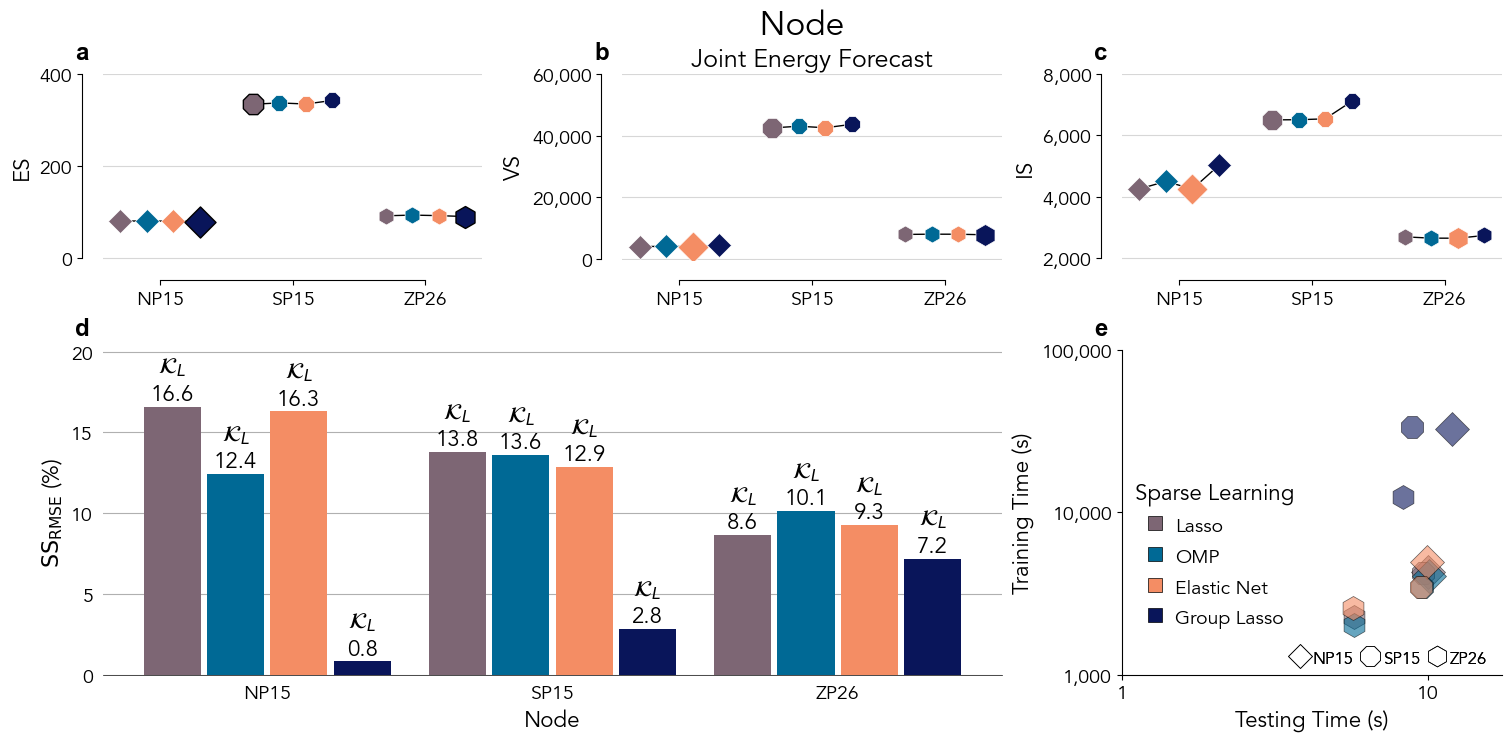

In [39]:
criteria = 'ES'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], 
                               ['d', 'd', 'e']], layout      = 'constrained', 
                                                 figsize     = (15, 7.), 
                                                 gridspec_kw = {'height_ratios': [1, 1.75]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")

_plot_results(_ax['a'], jt_ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'ES', 
                                                         y_min          = -3, 
                                                         y_max          = 400, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

_ax['b'].set_title('Joint Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], jt_ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'VS', 
                                                         y_min          = -200, 
                                                         y_max          = 60000, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])

_plot_results(_ax['c'], jt_ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'IS', 
                                                         y_min          = 1950, 
                                                         y_max          = 8000, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('          Node', fontsize = 24, y = 1.04)

_plot_node_fs(_ax['d'], jt_ts_scores_, zones_, colors_1_, 
              score          = criteria, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
              xlabel         = 'Node',
              ylabel         = '$\mathrm{SS}_{\mathrm{RMSE}}$ (%)',
              legend_title   = 'Sparse Learning',
              legend         = True,
              y_min          = 0, 
              y_max          = 20.1)

_plot_time(_ax['e'], jt_ts_scores_, 
           score    = criteria, 
           colors_  = colors_1_, 
           legend   = True, 
           x_max    = 20)

plt.savefig(path_to_images + f'jt_model_selection_{criteria}.pdf', bbox_inches = 'tight',
                                                                    dpi         = 300)

plt.show()

### Joint Node-Level Forecast - Variogram Score

ES NP15 lasso 77.33938701185578
ES NP15 OMP 76.40150020387385
ES NP15 elastic_net 78.6426490839649
ES NP15 group_lasso 79.79013614301482
ES SP15 lasso 323.06037474734416
ES SP15 OMP 328.3742608358345
ES SP15 elastic_net 325.38306693773023
ES SP15 group_lasso 342.1086710303653
ES ZP26 lasso 92.16194519965484
ES ZP26 OMP 91.93766373734988
ES ZP26 elastic_net 92.99580465793116
ES ZP26 group_lasso 90.55007931735258
VS NP15 lasso 4184.51295627056
VS NP15 OMP 4185.268016162498
VS NP15 elastic_net 4219.875492939339
VS NP15 group_lasso 4452.778190610196
VS SP15 lasso 42375.37302531468
VS SP15 OMP 42904.57632870485
VS SP15 elastic_net 42541.39234839269
VS SP15 group_lasso 43623.997551051434
VS ZP26 lasso 7964.559021776874
VS ZP26 OMP 7971.712147351055
VS ZP26 elastic_net 8028.539606840016
VS ZP26 group_lasso 7849.678368688991
IS NP15 lasso 5234.454009134553
IS NP15 OMP 5748.307061962268
IS NP15 elastic_net 5274.8335914469935
IS NP15 group_lasso 5021.752578531998
IS SP15 lasso 9395.135516427306


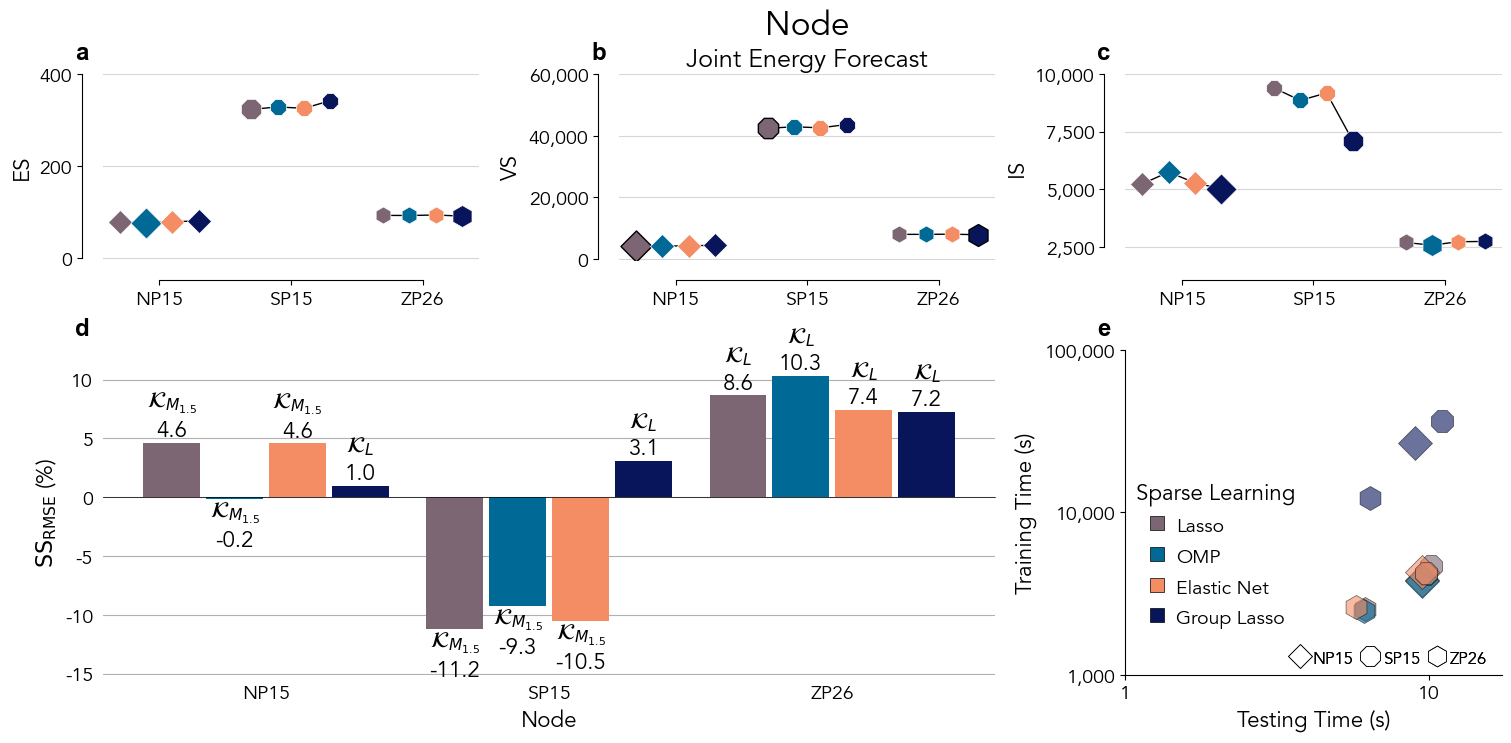

In [28]:
criteria = 'VS'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout      = 'constrained', 
                                                                  figsize     = (15, 7), 
                                                                  gridspec_kw = {'height_ratios': [1, 1.75]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")

_plot_results(_ax['a'], jt_ts_scores_, sl_methods_, zones_, 
              criteria       = criteria,
              score          = 'ES', 
              y_min          = -4, 
              y_max          = 400, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
              colors_        = colors_1_,
              legend_title   = 'Sparse Learning', 
              legend         = False, 
              decimals       = False)

_ax['b'].set_title('Joint Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], jt_ts_scores_, sl_methods_, zones_, 
              criteria       = criteria,
              score          = 'VS', 
              y_min          = -200, 
              y_max          = 60000, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
              colors_        = colors_1_,
              legend_title   = 'Sparse Learning', 
              legend         = False, 
              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])

_plot_results(_ax['c'], jt_ts_scores_, sl_methods_, zones_, 
              criteria       = criteria,
              score          = 'IS', 
              y_min          = 1950, 
              y_max          = 10000, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
              colors_        = colors_1_,
              legend_title   = 'Sparse Learning', 
              legend         = False, 
              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('           Node', fontsize = 24, y = 1.04)

_plot_node_fs(_ax['d'], jt_ts_scores_, zones_, colors_1_, 
              score          = criteria, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
              xlabel         = 'Node',
              ylabel         = '$\mathrm{SS}_{\mathrm{RMSE}}$ (%)',
              legend_title   = 'Sparse Learning',
              legend         = True,
              y_min          = -15.1, 
              y_max          = 12.5)

_plot_time(_ax['e'], jt_ts_scores_, 
           score    = criteria, 
           colors_  = colors_1_, 
           legend   = True, 
           x_max    = 20)

plt.savefig(path_to_images + f'jt_model_selection_{criteria}.pdf', bbox_inches = 'tight',
                                                                    dpi         = 300)

plt.show()

### Joint Node-Level Forecast - Interval Score

ES NP15 lasso 76.89318037212827
ES NP15 OMP 77.51439924585311
ES NP15 elastic_net 79.6784203607224
ES NP15 group_lasso 85.49139627121914
ES SP15 lasso 333.8292009098161
ES SP15 OMP 337.3698776802129
ES SP15 elastic_net 335.3159978373972
ES SP15 group_lasso 345.0113500028155
ES ZP26 lasso 92.20599061359958
ES ZP26 OMP 93.53070564605187
ES ZP26 elastic_net 92.38956681999365
ES ZP26 group_lasso 89.55606658869891
VS NP15 lasso 3841.8822935557628
VS NP15 OMP 3932.4371046775473
VS NP15 elastic_net 3985.993217209357
VS NP15 group_lasso 4750.59802301005
VS SP15 lasso 42438.35742030867
VS SP15 OMP 43066.39388536018
VS SP15 elastic_net 42611.19950487347
VS SP15 group_lasso 44019.80816705181
VS ZP26 lasso 7960.107256719359
VS ZP26 OMP 8024.312016675691
VS ZP26 elastic_net 8004.836000459256
VS ZP26 group_lasso 7887.263825378645
IS NP15 lasso 4411.799472750667
IS NP15 OMP 4392.041240453073
IS NP15 elastic_net 4408.976190254194
IS NP15 group_lasso 6015.607650445822
IS SP15 lasso 6505.455583660861
IS

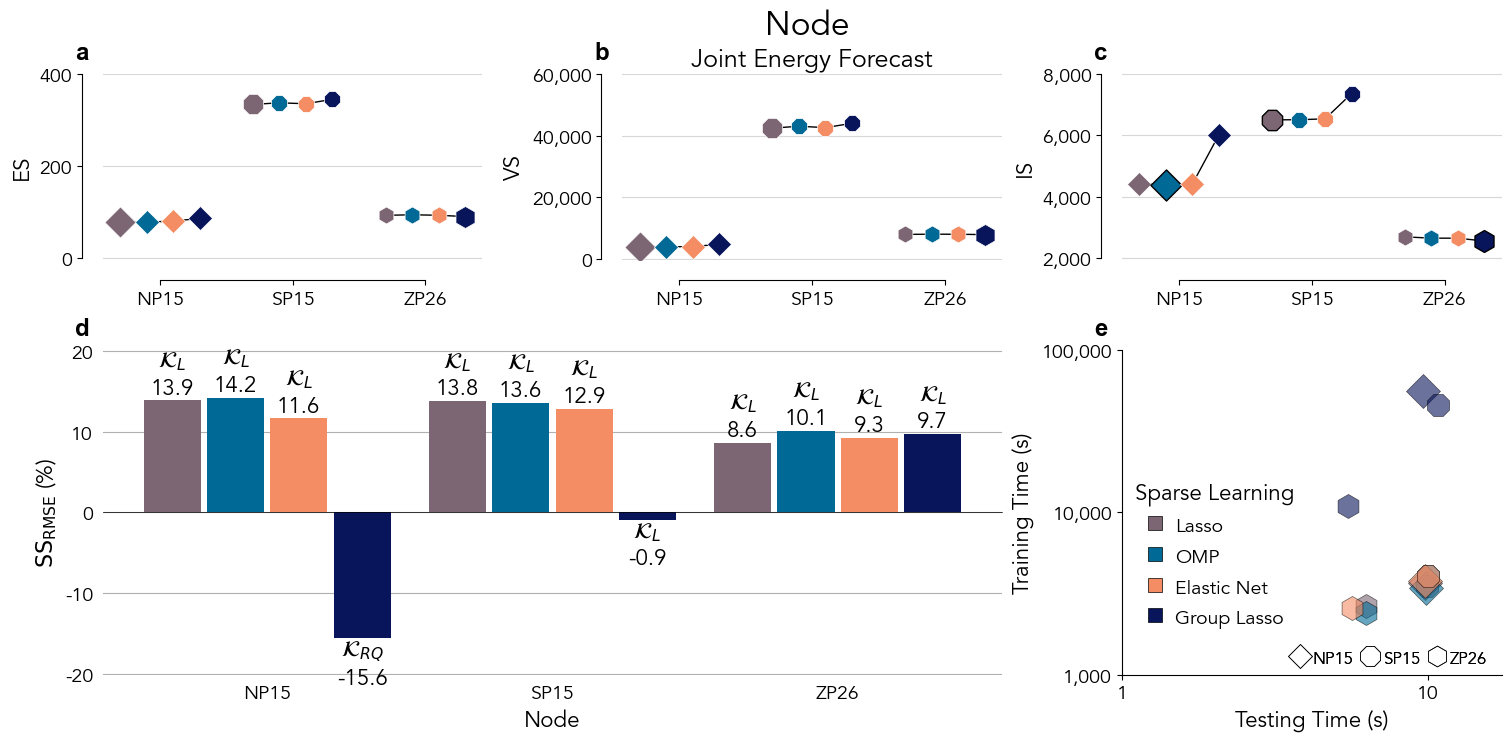

In [29]:
criteria = 'IS'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], 
                               ['d', 'd', 'e']], layout      = 'constrained', 
                                                 figsize     = (15, 7), 
                                                 gridspec_kw = {'height_ratios': [1, 1.75]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")

_plot_results(_ax['a'], jt_ts_scores_, sl_methods_, zones_, 
              criteria       = criteria,
              score          = 'ES', 
              y_min          = -4, 
              y_max          = 400, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
              colors_        = colors_1_,
              legend_title   = 'Sparse Learning', 
              legend         = False, 
              decimals       = False)

_ax['b'].set_title('Joint Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], jt_ts_scores_, sl_methods_, zones_, 
              criteria       = criteria,
              score          = 'VS', 
              y_min          = -200, 
              y_max          = 60000, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
              colors_        = colors_1_,
              legend_title   = 'Sparse Learning', 
              legend         = False, 
              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])

_plot_results(_ax['c'], jt_ts_scores_, sl_methods_, zones_, 
              criteria       = criteria,
              score          = 'IS', 
              y_min          = 1950, 
              y_max          = 8000, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
              colors_        = colors_1_,
              legend_title   = 'Sparse Learning', 
              legend         = False, 
              decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('           Node', fontsize = 24, y = 1.04)

_plot_node_fs(_ax['d'], jt_ts_scores_, zones_, colors_1_, 
              score          = criteria, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
              xlabel         = 'Node',
              ylabel         = '$\mathrm{SS}_{\mathrm{RMSE}}$ (%)',
              legend_title   = 'Sparse Learning',
              legend         = True,
              y_min          = -20.1, 
              y_max          = 20.1)

_plot_time(_ax['e'], jt_ts_scores_, 
           score    = criteria, 
           colors_  = colors_1_, 
           legend   = True, 
           x_max    = 20)

plt.savefig(path_to_images + f'jt_model_selection_{criteria}.pdf', bbox_inches = 'tight',
                                                                   dpi         = 300)

plt.show()